In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms 
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import zipfile

In [2]:
#transform the data
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),               
 transforms.ToTensor(),                     
 transforms.Normalize(                     
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                 
 )])

In [3]:
# Load the dataset anf apply the transformation 
train_data = torchvision.datasets.ImageFolder(root="train",transform=transform)
test_data = torchvision.datasets.ImageFolder(root="test",transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle=True, num_workers=2 )
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 4, shuffle=True, num_workers=2 )

classes = ("COVID-19", "normal", "pneumomia")

In [4]:
print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 14729
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 3076
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1= nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2= nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv3= nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform(self.conv3.weight)
        self.conv4= nn.Conv2d(in_channels=15, out_channels=20, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform(self.conv4.weight)
        
     
        self.pool = nn.AvgPool2d(2)
        self.dropout1 = nn.Dropout(p=0.5)
        self.softmax = nn.LogSoftmax(dim=1)

        self.bn1 = nn.BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = nn.BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn3 = nn.BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = nn.BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.linear1 = nn.Linear(in_features=3920, out_features=1024, bias=True)
        self.linear2 = nn.Linear(in_features=1024, out_features=256, bias=True)
        
    def forward(self, x):
       
        # frist convolution block/
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # second convolution block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # third convolution block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # forth convolution block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # flating
        x = x.view([-1,3920]) # [batch_size, 3920]
        
        # first fully connected layer
        x = F.relu(self.linear1(self.dropout1(x)))
        
        #second fully connected layer
        x= self.softmax(self.linear2(x))
                
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':


Net(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax()
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=3920, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
)

In [7]:
#optimizer and loss function
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use Adam as optimizer.
opt = optim.Adam(net.parameters()) 

In [8]:
avg_losses = []   # Avg. losses.
epochs = 50       # Total epochs.
print_freq = 500  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(train_loader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   499] avg mini-batch loss: 0.750
[epoch: 0, i:   999] avg mini-batch loss: 0.528
[epoch: 0, i:  1499] avg mini-batch loss: 0.516
[epoch: 0, i:  1999] avg mini-batch loss: 0.499
[epoch: 0, i:  2499] avg mini-batch loss: 0.463
[epoch: 0, i:  2999] avg mini-batch loss: 0.431
[epoch: 0, i:  3499] avg mini-batch loss: 0.435
[epoch: 1, i:   499] avg mini-batch loss: 0.388
[epoch: 1, i:   999] avg mini-batch loss: 0.389
[epoch: 1, i:  1499] avg mini-batch loss: 0.382
[epoch: 1, i:  1999] avg mini-batch loss: 0.365
[epoch: 1, i:  2499] avg mini-batch loss: 0.368
[epoch: 1, i:  2999] avg mini-batch loss: 0.358
[epoch: 1, i:  3499] avg mini-batch loss: 0.384
[epoch: 2, i:   499] avg mini-batch loss: 0.324
[epoch: 2, i:   999] avg mini-batch loss: 0.359
[epoch: 2, i:  1499] avg mini-batch loss: 0.295
[epoch: 2, i:  1999] avg mini-batch loss: 0.300
[epoch: 2, i:  2499] avg mini-batch loss: 0.336
[epoch: 2, i:  2999] avg mini-batch loss: 0.327
[epoch: 2, i:  3499] avg mini-batch loss

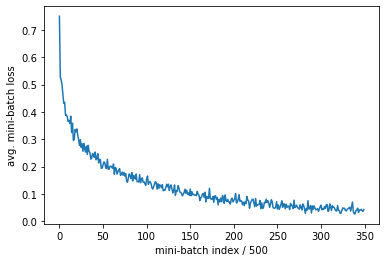

In [9]:
#training loss curve
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [10]:
# Get test accuracy.
correct = 0
total = 0

labelsForAUC = []
predictFOrAUC = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labelsForAUC.append(labels.cpu().numpy())
        predictFOrAUC.append(predicted.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))




Accuracy of the network on the test images: 87 %


In [11]:
label= np.concatenate( labelsForAUC, axis=0)
predict = np.concatenate( predictFOrAUC, axis=0)

In [12]:
cMatrix = confusion_matrix(y_true=label,y_pred=predict,labels=[0, 1, 2])

Text(0.5, 0.98, 'Confusion Matrix')

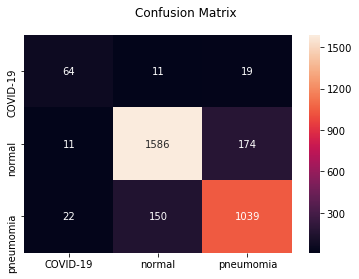

In [13]:
ax = sn.heatmap(cMatrix,annot=True,fmt="d",xticklabels=classes,yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


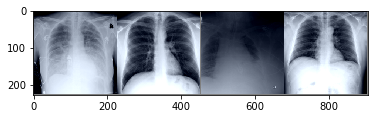

GroundTruth:  pneumomia normal pneumomia normal
Predicted:  pneumomia normal COVID-19 normal


In [14]:
# The function to show an image.
def imshow(img):
    img = img / 3.33 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Check several images.
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))